# Dispersion modelling in a python notebook

In [2]:
# imports 
import os, sys, time, numpy as np
import gdal
import scipy
import pandas as pd
from scipy.ndimage import *
from scipy.misc import imfilter
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import time
import ogr
import osr

## Import the raster of emissions data

In [3]:
# open the image with gdal- this example reads in a 34,000,000 pixel file
g = gdal.Open(r'F:\work_projects\RapidAir\test_fft_algorithm\emissions.tif')
# get the data in the first raster band- this is our emissions
b = g.GetRasterBand(1)
# convert the data to a numpy array
imgdata = b.ReadAsArray()
# provide the number of rows and columns in the array- these can be used to shape outputs for example
print('Rows: %d, columns: %d' % (imgdata.shape[0], imgdata.shape[1]))

Rows: 4951, columns: 5005


## Prep the raster for later georeferencing of outputs

In [6]:
# get the corners
width = g.RasterXSize
height = g.RasterYSize
gt = g.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]  # from http://gdal.org/gdal_datamodel.html
maxx = gt[0] + width*gt[1] + height*gt[2]  # from http://gdal.org/gdal_datamodel.html
maxy = gt[3]

domainarea = int((maxx-minx) * (maxy-miny))/1000000 # convert to km2

print "The lower left corner of the raster is at %s , %s" % (minx, miny)
print "The upper right corner of the raster is at %s, %s" % (maxx, maxy)
print "The domain area of the emissions grid is %s km2" % (domainarea)

# calculate the resolution (should be the same as the AERMOD input file
xresolution = int((maxx - minx) / imgdata.shape[1])
yresolution = int((maxy - miny) / imgdata.shape[0])
kernelarea  = int(xresolution * yresolution)

# return the resolution values
print "The horizontal resolution of the emissions grid is %s m, the vertical resolution is %s m" % (xresolution, yresolution)
print "The area of the cells is %s m2 each" % (kernelarea)

The lower left corner of the raster is at 301522.5 , 680442.1125
The upper right corner of the raster is at 316537.5, 695295.1125
The domain area of the emissions grid is 223 km2
The horizontal resolution of the emissions grid is 3 m, the vertical resolution is 3 m
The area of the cells is 9 m2 each


## Some plotting

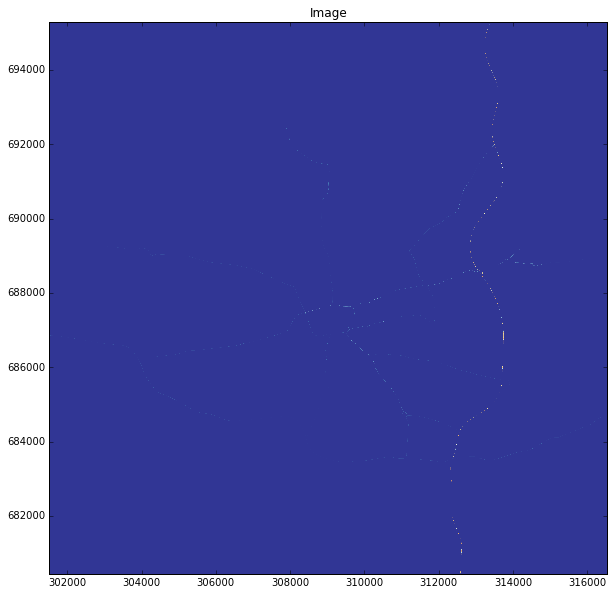

In [5]:
# assign rows and column lengths to variables
xdim = imgdata.shape[1] # note this can appear back to front at first glance- the xdim is of course the number of columns
ydim = imgdata.shape[0]
get_ipython().magic(u'matplotlib inline')
'''
use the rows and columns to assign the correct vertices- here we've multiplied the xdim and ydim by 10 to 
simulate cells representing a raster with cells of 10m in the x and y axes- useful for geoprocessing
'''
plt.figure(figsize=(10,10))
plt.imshow(imgdata, extent = (minx, maxx, miny, maxy), cmap = 'RdYlBu_r')  
plt.title('Image')
plt.show()

## Read in AERMOD kernel file

In [9]:
# load aermod file
data = np.loadtxt(r'F:\work_projects\RapidAir\test_fft_algorithm\Period.plt', 
                  skiprows = 8, usecols = (0,1,2))

# set the z variable as the concentration column
z = data[:,2]

# reshape the data to 55x55 array
z = np.reshape(z, (55,55))

# flip the array from top to bottom keeping the columns in the right order left to right
z_flipped = np.flipud(z) 

# note np.fluplr() is to flip horizontal
# np.rot90() rotates the array through 90 degree
print z_flipped
print "This array has now been flipped, so the values are in the right indices assuming the x and y origin is 0,0 in the input data from AERMOD e.g."


[[ 252.2265   255.92839  259.47539 ...,  233.71495  232.41564  231.2958 ]
 [ 265.80087  269.8157   273.86313 ...,  248.68769  247.42894  246.44428]
 [ 280.78358  284.93856  289.3252  ...,  265.35565  264.27601  263.17759]
 ..., 
 [ 503.60675  499.41951  494.16982 ...,  498.14783  483.40986  468.71333]
 [ 466.157    461.38534  455.75085 ...,  478.93189  465.55486  452.15444]
 [ 431.73356  426.67684  420.99447 ...,  460.19118  448.27859  436.10929]]
This array has now been flipped, so the values are in the right indices assuming the x and y origin is 0,0 in the input data from AERMOD e.g.


## Plot out the kernel array

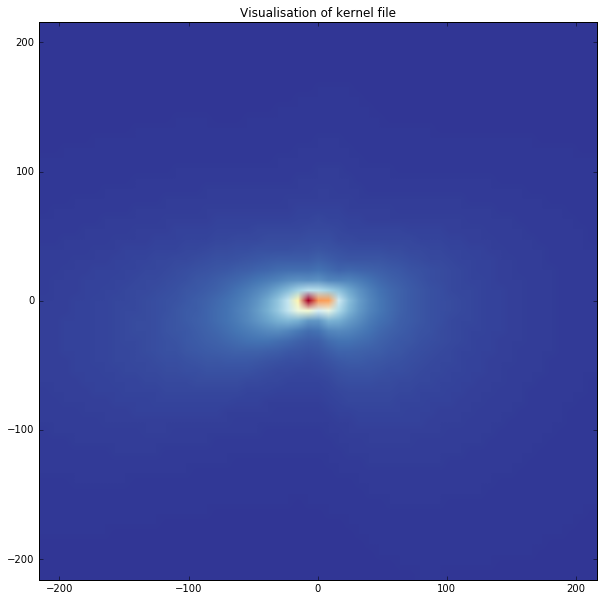

that took
(0.2390000820159912, 'seconds')


In [18]:
# plot out the array we just made (could be a kernel)
# assign rows and column lengths to variables
start = time.time()

xdim = z_flipped.shape[1] # note this can appear back to front at first glance- the xdim is of course the number of columns
ydim = z_flipped.shape[0]
plt.figure(figsize=(10,10))
plt.imshow(z_flipped, extent = (-216, 216, -216, 216), cmap = 'RdYlBu_r')  # center of file is 0,0, edges should be half the dim
plt.title('Visualisation of kernel file')
plt.show()

print("that took")
end = time.time()
print(end - start, "seconds")

# ## Convolution model 1: Based on ndimage.convolve, this produces a plot in about 90 sec for this case (around Dufermline, 3m resolution)


C:\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


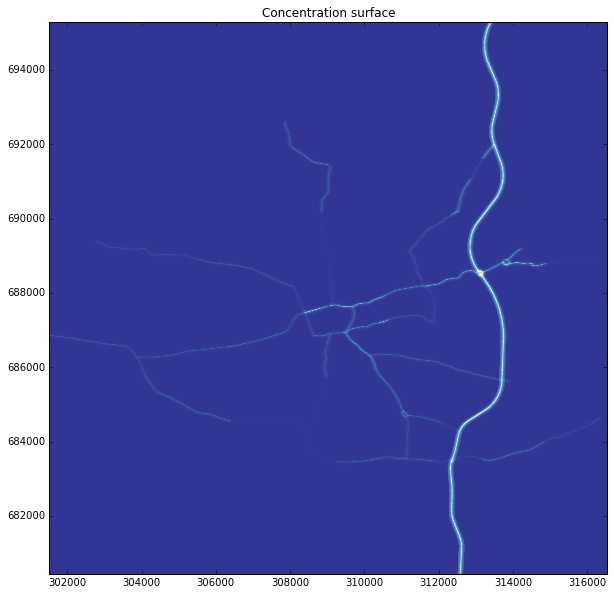

that took
(89.64800000190735, 'seconds')


In [11]:
# start clock for run time calculation
start = time.time()

# plot the convolved image
from scipy import ndimage
new_data = ndimage.convolve(imgdata, z_flipped, mode='constant', cval=0.0)/3025 # 3025 is the number of kernel cells
plt.figure(figsize=(10,10))
plt.imshow(new_data,  extent = (minx, maxx, miny, maxy), cmap = 'RdYlBu_r', label = 'concentrations')  
plt.title('Concentration surface')
plt.legend(loc='best')
plt.show()

# show run time
print("that took")
end = time.time()
print(end - start, "seconds")

## Make a csv of the dispersion modelling result for ndimage.convolve


In [21]:
# spit out image as a csv file - the concentrations can be read in a text editor
np.savetxt('F:\\work_projects\\RapidAir\\test_fft_algorithm\\ndimage_output.csv', new_data, delimiter=',', fmt='%2.2f')

In [22]:
## Make a raster and georeference it

In [24]:
# make a raster from ndimage model in the folder defined at the bottom.
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(27700)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

rasterOrigin = (minx, miny)
pixelWidth = xresolution
pixelHeight = yresolution
newRasterfn = 'F:\\work_projects\\RapidAir\\test_fft_algorithm\\output_array.tif'
array = new_data

main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)

# Convolution model 2: Based on fftconvolve, this produces a plot in about 7 sec for this case (same domain, 3m resolution).

## fftconvolve is much faster than the ndimage routine. http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html


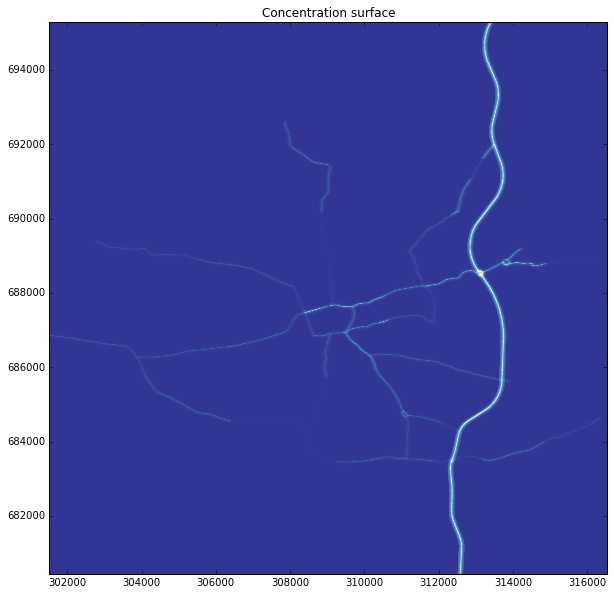

that took
(7.66100001335144, 'seconds')


In [26]:
# start clock for run time calculation
start = time.time()

# compute convolution
from scipy import signal
fft_convolved = signal.fftconvolve(imgdata, z_flipped, mode='same')/3025 # number of cells in kernel

# plot it out
plt.figure(figsize=(10,10))
plt.imshow(fft_convolved,  extent = (minx, maxx, miny, maxy), cmap = 'RdYlBu_r', label = 'concentrations')  
plt.title('Concentration surface')
plt.legend(loc='best')
plt.show()

# show run time
print("that took")
end = time.time()
print(end - start, "seconds")

In [28]:
# make a raster from fftconvolved model in the folder defined at the bottom.
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(27700)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

rasterOrigin = (minx, miny)
pixelWidth = xresolution
pixelHeight = yresolution
newRasterfn = 'F:\\work_projects\\RapidAir\\test_fft_algorithm\\fftcon_array.tif'
array = fft_convolved

main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)


 ...]

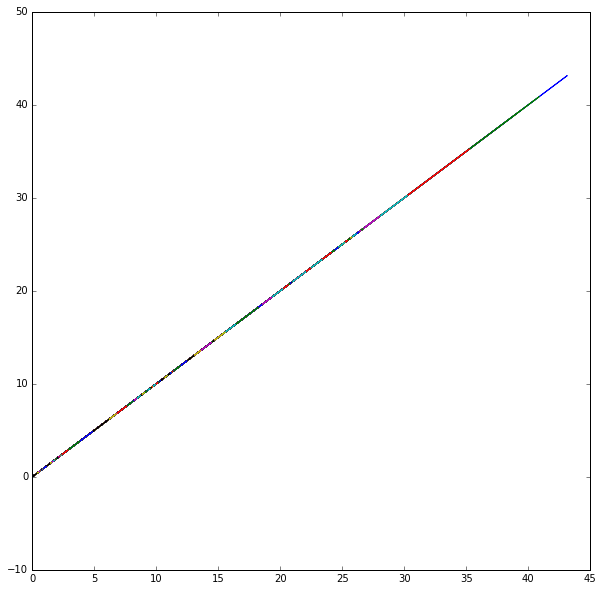

In [29]:
from scipy import stats
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(new_data, fft_convolved)